<a href="https://colab.research.google.com/github/BeatriceCamera/Deep-Learning-Project/blob/main/DLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project**

This project addresses a supervised learning task involving hotel reviews, written by 13772 visitors. The goal is to predict both the review type, negative or positive, and the review score, ranging from 2.5 to 10.

I begin by importing the dataset directly from my Github depository and then display the first five rows to inspect the structure and the content of the data.

In [ ]:
import pandas as pd

# Define the raw URL to the dataset hosted on GitHub
url = "https://raw.githubusercontent.com/BeatriceCamera/Deep-Learning-Project/main/input_data.csv"

# Load the CSV file directly from the URL into a pandas DataFrame
df = pd.read_csv(url)

# Display the first five rows of the DataFrame for inspection
df.head()

,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
1,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
2,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
3,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
4,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


Each row of this dataset corresponds to a single review and includes features such as the hotel's address, name, the reviewer's nationality, the date of the review...  Among the columns, the most relevant for the task are:


*   `Review`: the whole text of the review, which will serve as an input to a text-processing model.
*   `Review_Score`:  the numerical score given to the hotel to be predicted as a regression output.
*   `Review_Type`: the binary label indicating whether the review is negative or positive, which will be the classification output.

The dataset includes tabular features as well.







Now, I explore better the dataset, checking for missing values and gaining an overall understanding of the data types.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hotel_Address            13772 non-null  object 
 1   Review_Date              13772 non-null  object 
 2   Average_Score            13772 non-null  float64
 3   Hotel_Name               13772 non-null  object 
 4   Reviewer_Nationality     13772 non-null  object 
 5   Hotel_number_reviews     13772 non-null  int64  
 6   Reviewer_number_reviews  13772 non-null  int64  
 7   Review_Score             13772 non-null  float64
 8   Review                   13772 non-null  object 
 9   Review_Type              13772 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.1+ MB


The dataset contains 10 columns with mixed datatypes:

*   Mix of numerical datatypes (`int64`, `float64`)
*   Textual features (`object`)

Moreover, there are no missing values.

Before applying any operations to the dataset, I want to assess class imbalances in the target variables. Indeed, imbalances have significant implications for the analysis of the dataset and a model trained on an imbalance dataset may predominantly predict the majority class due to its higher frequency.

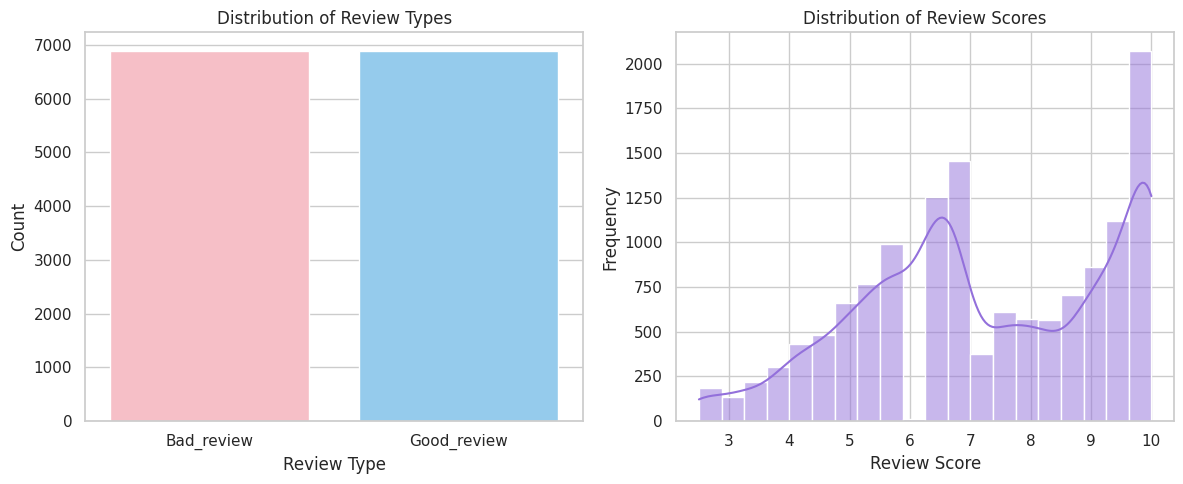

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style globally
sns.set(style="whitegrid")

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: Review_Type distribution.
sns.countplot(ax=axes[0], x='Review_Type', data=df, hue='Review_Type',
              palette={"Bad_review": "#FFB6C1", "Good_review": "#87CEFA"})
axes[0].set_title('Distribution of Review Types')
axes[0].set_xlabel('Review Type')
axes[0].set_ylabel('Count')

# Right plot: Review_Score distribution.
sns.histplot(ax=axes[1], data=df, x='Review_Score', bins=20, kde=True, color="#9370DB")
axes[1].set_title('Distribution of Review Scores')
axes[1].set_xlabel('Review Score')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

The firts plot of the Review Types distribution shows that the two classes are balanced, with a very similar number of samples in each category.

The second plot, which displays the continuous review scores, reveals a slight right-skewed distribution with two prominent peaks, one around the score 10 and a smaller one near score 7. This indicates that most users tend to give high scores. However, normalization techniques should be able to necessarily reduce the impact of outliers.

## **Preprocessing**

I begin by separating the two target variables and dropping two columns:


*   `Average_Score`
*   `Hotel_Address`, since it is a high cardinality categorical feature with minimal predictive power in this context. Indeed, the address does not directly contribute meaningful information for predicting the sentiment or content of a single review.



In [ ]:
# Separate the targets from the features
y_type = df['Review_Type']                # classification target
y_score = df[['Review_Score']]            # regression target (must be 2D for MinMaxScaler)
text_data = df['Review']

df.drop(['Average_Score', 'Hotel_Address'], axis=1, inplace=True)

### **Train and Test Splitting**

Now, I split the dataset into training and test sets, making sure to keep all inputs and targets aligned. Since the model has two types of input and two targets I split them all at once. This ensures that each example remains consistent across inputs and labels. I apply stratification based on the classification target to preserve the distribution of classes in both training and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_tab_train_raw, X_tab_test_raw, \
X_text_train_raw, X_text_test_raw, \
y_class_train_raw, y_class_test_raw, \
y_score_train_raw, y_score_test_raw = train_test_split(
    df.drop(columns=['Review', 'Review_Type', 'Review_Score']),
    text_data,
    y_type,
    y_score,
    test_size=0.2,
    random_state=42,
    stratify=y_type
)

### **Textual Preprocessing**

To begin preprocessing the dataset, I focus first on the textual data, in particular the column containing the review text. Since this feature is written in natural language, it requires dedicated cleaning and preparation before it can be passed to a deep learning model.

First, I download the list of common stopwords, such as "the", "is", "and"..., from the NLTK library.

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Define the stopword list in English
stop_words = set(stopwords.words('english'))

Now, I actually start to preprocess the text input by defining a function that takes as input a single review and applies several preprocessing steps:


1.   Replace double dashes with a space.
2.   Tokenize the sentence using a natural language processor that accurately separates words, punctuation, and contractions.
3. Remove punctuation from each tokens to clean the text.
4. Keep only alphabetic tokens, removing numbers, symbols, any mixed tokens...
5. Normalize all words to lowercase.
6. Remove stopwords. They are common and non-informative words, since they do not carry useful sentiment or meaning.



In [ ]:
import string
from nltk.tokenize import word_tokenize

def clean_review(text):
    # Replace double dashes with a space
    text = text.replace('--', ' ')
    # Split the text into tokens using whitespace
    words = word_tokenize(text)
    # Remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]
    # Keep only alphabetic tokens
    words = [word for word in words if word.isalpha()]
    # Convert all words to lowercase
    words = [word.lower() for word in words]
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return words

# Apply your clean_review function to each review in the dataset
cleaned_train_reviews = X_text_train_raw.apply(clean_review)
cleaned_test_reviews = X_text_test_raw.apply(clean_review)

# Flatten the list of tokenized reviews into one big list of words
all_words = [word for review in cleaned_train_reviews for word in review]

# Compute statistics
tot_uniq_words = len(set(all_words))

# Print sample output
print(all_words[:200])
print(f"Total words: {len(all_words)}")
print(f"Unique words: {tot_uniq_words}")

['clean', 'room', 'refil', 'tea', 'coffee', 'facilities', 'scaffolding', 'blocking', 'view', 'location', 'expensive', 'staff', 'reception', 'rude', 'respect', 'guests', 'specially', 'peak', 'times', 'occupancy', 'hotel', 'high', 'front', 'desk', 'staff', 'work', 'pressure', 'location', 'hotel', 'extremely', 'noisy', 'main', 'road', 'mornings', 'hot', 'water', 'shower', 'forgot', 'mention', 'booking', 'take', 'guarantee', 'also', 'staff', 'let', 'room', 'without', 'knocking', 'getting', 'ready', 'go', 'see', 'maids', 'cleaned', 'room', 'apology', 'walking', 'room', 'small', 'meant', 'deluxe', 'double', 'room', 'would', 'hate', 'standard', 'room', 'nice', 'hotel', 'good', 'location', 'definitely', 'worth', 'money', 'charge', 'good', 'location', 'good', 'breakfast', 'air', 'con', 'rooms', 'boiling', 'hot', 'shower', 'work', 'bad', 'th', 'buffet', 'breakfast', 'great', 'arrived', 'morocco', 'stayed', 'star', 'treated', 'like', 'royalty', 'arrived', 'hotel', 'hardly', 'greeted', 'even', 'sm

After applying the `clean_review` function to each row in the dataset, we obtain a cleaned version of the text reviews. Each review is now represented as a list of meaningful tokens, with punctuation, numbers, and common stopwords removed.

Now, I build a dictionary by collecting all the unique words from the cleaned reviews and create a dictionary mapping each unique word to a unique integer index. This transformation is necessary to convert text into numerical sequences that can be processed by a neural network.  

In [ ]:
import numpy as np

# Extract the unique words using numpy
unique_words = np.unique(all_words)

# Convert to Python strings to avoid np.str_ in output
unique_words = unique_words.tolist()

# Create a dictionary mapping each unique word to a unique integer
unique_word_index = dict((word, idx) for idx, word in enumerate(unique_words))

After building the dictionary that maps each word to an integer, I convert each review into a sequence of integers, where each token is replaced by its corresponding index. This transformation is necessary to make the text input compatible with a neural network model (in this case LSTM), which requires numerical input.

In [ ]:
# Convert each review to a sequence of integers using the custom dictionary
sequences_train = [[unique_word_index[word] for word in review if word in unique_word_index] for review in cleaned_train_reviews]
sequences_test = [[unique_word_index[word] for word in review if word in unique_word_index] for review in cleaned_test_reviews]

I applied padding to the input sequences in order to ensure they all have the same length. Indeed, this step is required by Recurrent Neural Networks, which expect inputs of fixed dimensions. Padding does not change the content of the original data but adds zeros to make all sequences the same size.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Determine the maximum sequence length
max_sequence_length = max(len(seq) for seq in sequences_train)

# Pad the sequences so that all have the same length
X_text_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_text_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

### **Tabular preprocessing**

I start by converting the `Review_date`column into a proper datetime format. From this, I extract three new features: day, month and year, which I store in specific columns.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd

for df_raw in [X_tab_train_raw, X_tab_test_raw]:
    # Extract the day, month and year component
    df_raw['Review_Date'] = pd.to_datetime(df_raw['Review_Date'], format='%m/%d/%Y', errors='coerce')
    df_raw['Day'] = df_raw['Review_Date'].dt.day
    df_raw['Month'] = df_raw['Review_Date'].dt.month
    df_raw['Year'] = df_raw['Review_Date'].dt.year
    # Drop original column
    df_raw.drop(columns=['Review_Date'], inplace=True)

I define two lists:


*   one for the categorical features, which will be one-hot encoded.
*   one for the numerical features, which will be normalized.

These lists will guide how I process each datatype, since we have seen in the exploration of the dataset that there are mixed datatypes.



In [ ]:
categorical_features = ['Hotel_Name', 'Reviewer_Nationality']
numerical_features = ['Hotel_number_reviews', 'Reviewer_number_reviews', 'Day', 'Month', 'Year']

I start by applying one-hot encoding on the selected categorical features. This technique creates a new binary column for each unique category.

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_cat_train = ohe.fit_transform(X_tab_train_raw[categorical_features])
X_cat_test = ohe.transform(X_tab_test_raw[categorical_features])

Numerical features, on the other hand, are scaled to a [0,1] range using `MinMaxScaler`. This step is important because it ensures that all numerical values are on the same scale, which helps the model perform better.

In [ ]:
scaler = MinMaxScaler()
X_num_train = scaler.fit_transform(X_tab_train_raw[numerical_features])
X_num_test = scaler.transform(X_tab_test_raw[numerical_features])

I combine the categorical variables and the normalized numerical features into a single tabular set, that will serve as model input.

In [ ]:
X_tab_train = pd.DataFrame(np.hstack([X_cat_train.toarray(), X_num_train]))
X_tab_test = pd.DataFrame(np.hstack([X_cat_test.toarray(), X_num_test]))

For the targets:


*   I encode `Review_Type` column by mapping `Good_Review` to 1 and `Bad_Review` to 0.
*   I normalize `Review_Score` column to a [0,1] range using `MinMaxScaler`, preparing it for the regression task. The `Review_Scores` range from 2.5 to 10. Although I do not explicitly set this range, `MinMaxScaler` automatically adapts to the minimum and maximum value of the data.



In [ ]:
# Encode classification labels (train and test separately)
y_class_train = (y_class_train_raw == "Good_review").astype(int)
y_class_test = (y_class_test_raw == "Good_review").astype(int)

# Normalize regression target using only training data
score_scaler = MinMaxScaler()
y_score_train = score_scaler.fit_transform(y_score_train_raw)
y_score_test = score_scaler.transform(y_score_test_raw)

After the preprocessing step:


*   The textual input is represented as a sequence of integers representing word indices.
 * Type: Integer
 * Shape: `(sequence lenght,)`
 * Value Domain: integers in [0, vocabulary size - 1] where each index corresponds to a unique token from the cleaned reviews.
*   The tabular input is a vector of numerical features, including one-hot encoded categorical variables and normalized numerical ones.
 * Type: Float
 * Shape: `(number of features,)`
 * Value Domain: all values are real numbers in [0,1] due to normalization and one-hot encoding.



## **Model Architecture**

To solve this multi-output problem, I designed a neural architecture that uses two separate branches:


*   An LSTM network for the textual data.
*   An MLP for the tabular data.

After processing each input separately, I merge the two models with a concatenation layer, so the final prediction can rely both on textual and tabular features. This merged representation is then fed into two ouput layers: one for the binary classification for the review type and one for predicting the review score as a regression task. Both output layers depend on information from both inputs, allowing the model to learn joint representation across modalities.



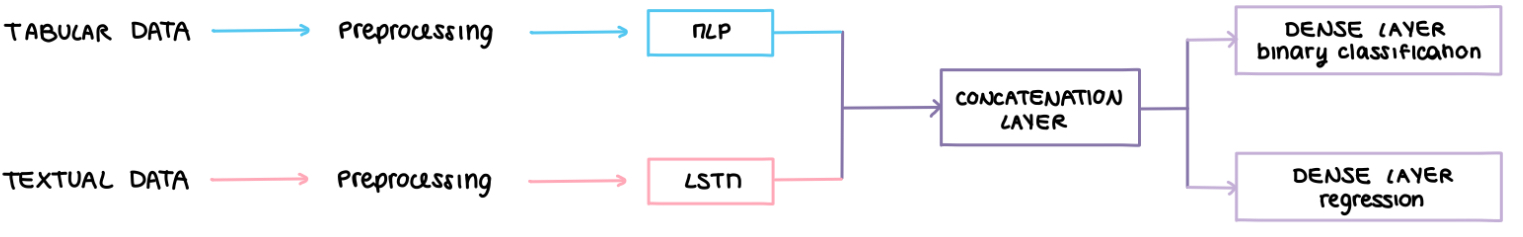

### **Multi Layer Perceptron**

MLP is a feedforward fully connected neural network of perceptron organized in multiple layers. Each perceptron feeds its output to the subsequent ones in deeper layers forming a hierarchical structure.

Here, I have defined a function that takes the tabular data as inputs and passes it through two fully connected layers. The first dense layer uses a specified number of units and the second half as many. Both layers apply the ReLu activation function and uses HeNormal initializer to ensure a good weight initialization and avoid exploding gradient. To reduce the risk of overfitting, dropout layers are inerted after each dense layer.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.initializers import HeNormal

def build_mlp(input_dim, n_units_tab, dropout_rate=0.2):
    model = Sequential([
        InputLayer(shape=(input_dim,)),
        Dense(n_units_tab, activation='relu', kernel_initializer=HeNormal()),
        Dropout(dropout_rate),
        Dense(n_units_tab // 2, activation='relu', kernel_initializer=HeNormal()),
        Dropout(dropout_rate)
    ])
    return model

### **LSTM**

Long Short Term Memory which is a type of recurrent neural network designed to handle long-term dependencies and prevent the unstable gradient problems.

The branch begins with an embedding layer that trasforms each word index, generated from the custom vocabulary, into a dense vector representation of fixed dimensionality. These word embeddings allow the model to capture semantic similarities between words and serve as the input to subsequent LSTM layers.

This LSTM branch operates in parallel with the MLP one, and its learned representation is ultimately merged with that of the MLP to perform joint binary classification and regression task

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Input
from tensorflow.keras.initializers import HeNormal, GlorotUniform

def build_lstm(max_seq_len, vocab_size, embed_dim, n_units_lstm, dropout_rate=0.2):
    # Input layer for padded sequences
    text_input = Input(shape=(max_seq_len,), name='text_input')

    # Embedding layer initialized randomly
    x = Embedding(input_dim=vocab_size,
                  output_dim=embed_dim,
                  name='embedding_layer')(text_input)

    # LSTM layer
    x = LSTM(n_units_lstm,
             return_sequences=False,
             kernel_initializer=GlorotUniform(),
             name='lstm_layer')(x)

    # Dropout for regularization
    x = Dropout(dropout_rate, name='dropout_lstm')(x)

    return text_input, x

### **Concatenation of MLP and RNN**

Subsequentially, I define the function that defines the final architecture by merging the tabular and textual branches. The MLP handles structured numerical input, while the LSTM processes preprocessed sequences from the review text. Each branch encodes its respective input independently. Their outputs are then concatenated into a shared representation, which feeds two output layers:

*   One for binary classification, where the sigmoid activation function is used to map the output to a probability between 0 and 1, suitable for distinguishing between the two classes.
*   One for score regression, where the sigmoid activation is used because the target scores have been normalized between 0 and 1, ensuring model's predictions remain within the same range.  



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

def build_combined_model(n_units_tab, n_units_lstm, embed_dim, dropout_rate=0.2):
    # Tabular Input
    tabular_input = Input(shape=(X_tab_train.shape[1],), name='tabular_input')
    mlp_model = build_mlp(X_tab_train.shape[1], n_units_tab, dropout_rate=dropout_rate)
    mlp_output = mlp_model(tabular_input)

    # Textual Input
    text_input, lstm_output = build_lstm(
        max_seq_len=max_sequence_length,
        vocab_size=tot_uniq_words,
        embed_dim=embed_dim,
        n_units_lstm=n_units_lstm,
        dropout_rate=dropout_rate
    )

    # Branch Merge
    combined = concatenate([lstm_output, mlp_output], name='combined_features')

    # Output layers
    classification_output = Dense(1, activation='sigmoid', name='classification_output')(combined)
    regression_output = Dense(1, activation='sigmoid', name='regression_output')(combined)

    # Final model
    model = Model(inputs=[text_input, tabular_input], outputs=[classification_output, regression_output])
    return model

The model, as I have already said, has a dual-output structure, as it is designed to perform both classification and a regression task simultaneously.


*   Classification output, which uses a sigmoid activation function to return a probability for binary classification.
*   Regression output, which also uses a sigmoid activation to predict a continuous score normalized between 0 and 1.



Now, I verify that the model architecture is correctly defined and can be built without errors. To do so, I run a diagnostic script that attempts to instantiate the combined multi-input model using fixed hyperparameters. I also inspect the structure by printing the input and output layers shapes and see a detailed overview of the internal architecture.

In [ ]:
# Diagnostic code: model structure check

from tensorflow.keras.utils import plot_model
from termcolor import colored

n_units_tab = 128
n_units_lstm = 64
embed_dim = 50

try:
    model_test = build_combined_model(
        n_units_tab=n_units_tab,
        n_units_lstm=n_units_lstm,
        embed_dim=embed_dim
    )
except Exception as e:
    print(colored("Error while building the combined model:", "red"))
    raise e

print("INPUT LAYERS:")
for i, inp in enumerate(model_test.inputs):
    print(f" - Input {i+1}: name = '{inp.name}', shape = {inp.shape}")

print("\nOUTPUT LAYERS:")
for i, out in enumerate(model_test.outputs):
    print(f" - Output {i+1}: name = '{out.name}', shape = {out.shape}")

print("\nMODEL SUMMARY:")
model_test.summary()




INPUT LAYERS:
 - Input 1: name = 'text_input', shape = (None, 274)
 - Input 2: name = 'tabular_input', shape = (None, 1473)

OUTPUT LAYERS:
 - Output 1: name = 'keras_tensor_10', shape = (None, 1)
 - Output 2: name = 'keras_tensor_11', shape = (None, 1)

MODEL SUMMARY:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 274)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 274, 50)   │    508,200 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 64)        │     29,440 │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 1473)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_lstm        │ (None, 64)        │          0 │ lstm_layer[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │    196,928 │ tabular_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_features   │ (None, 128)       │          0 │ dropout_lstm[0][… │
│ (Concatenate)       │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │        129 │ combined_feature… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │        129 │ combined_feature… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 734,826 (2.80 MB)

 Trainable params: 734,826 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

The output confirms that the model is correctly structured and all components are working as expected. Also, all layers are connected appropriately, and there are no missing or incompatible shapes.

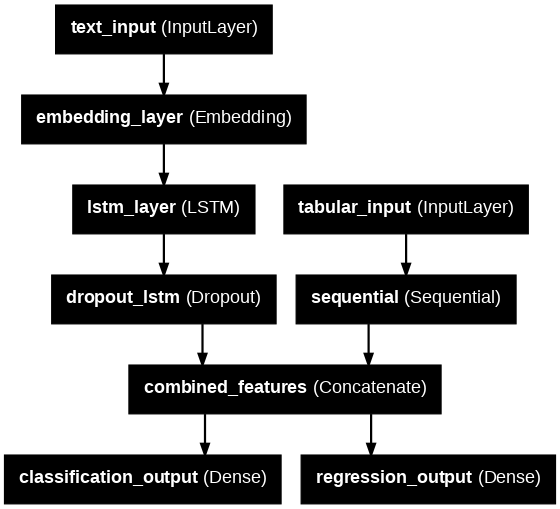

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate the model graph
plot_model(
    model_test,
    to_file="combined_model.png",
    show_shapes=False,
    show_layer_names=True,
    dpi=80
)

### **Loss function**

Now, I define the loss functions used for training the two outputs of the model.

Since the model has two distinct outputs, I will combine the two contributions into a single total loss. This allows the model to learn both tasks simultaneously while balancing their importance. In particular:

*   Classification output: binary cross entropy.
*   Regression output: mean squared error.

The two losses are then weighetd using coefficients λ1 and λ2, which controls the relative influence of each task on the training process. This results in the loss of the form:

$$
\text{Total Loss} = \lambda_1 \cdot \text{Binary Cross-entropy} + \lambda_2 \cdot \text{Mean Squared Error}
$$

The use of `loss_weight` in the model compilation ensures that this weighted sum is applied automatically by keras during training.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

losses = {
    "classification_output": BinaryCrossentropy(),
    "regression_output": MeanSquaredError()
}
loss_weights = {
    "classification_output": 0.5,  # lambda1
    "regression_output": 0.5       # lambda2
}

### **Hyperparameters Tuning and cross validation**

Now I set up the hyperparameters search space for model tuning.

I define a grid of possible values for each key parameter:

*   Hidden Units
*   Coefficient weights
* Optimizer type
* Batch size
* Epochs




 I decided to fix the number of units in the LSTM branch to 64, rather than tuning it. This choice was motivated by both computational and architectural considerations. Since the LSTM is mainly responsible for processing textual input and already has a balanced complexity, increasing or decreasing its dimensionality would have significantly raised the computational cost during cross-validation, without necessarily leading to consistent performance improvements. Therefore, the tuning process focused instead on the number of units in the MLP, which processes the tabular features and is more flexible in capturing structured patterns.

In [ ]:
from itertools import product

param_grid = {
    'n_units_tab': [32, 64, 128],
    'lambda1': [0.5, 1.0],
    'lambda2': [0.5, 1.0],
    'optimizer': ['adam', 'sgd'],
    'batch_size': [128],
    'epochs': [30]
}

To reduce even more the computational time and resource usage during hyperparameters tuning, I selected a random subset of 30% from the full training dataset. This subset includes the tabular data input, textual input, and both target outputs, allowing the cross-validation process to remain representative while being significantly faster.

In [ ]:
# Sample a subset of the training data (30%)
subset_size = int(len(X_tab_train) * 0.3)
subset_indices = np.random.choice(len(X_tab_train), subset_size, replace=False)

# Apply subset selection
X_tab_sub = X_tab_train.iloc[subset_indices]
X_text_sub = X_text_train[subset_indices]
y_class_sub = y_class_train.iloc[subset_indices]
y_score_sub = y_score_train[subset_indices]

I perform the cross validation based hyperparameter tuning on a subset of the training data. Using random sampling and stratified fold, it evaluates several models configurations to identify the one with the lowest average validation loss. This approach balanaces performance assessment and computational efficiency, helping to select the best parameters before training on the full dataset.

In [ ]:
import random
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
import tensorflow as tf

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Initialize Stratified K-Fold with 2 splits and fixed seed
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

best_loss = float('inf')
best_params = None

# Generate a random sample of hyperparameter combinations
param_combinations = list(ParameterSampler(param_grid, n_iter=5, random_state=42))

# Cross-validation loop
for params in param_combinations:
    print("\nEvaluating configuration:", params)

    loss_weights = {
        'classification_output': params['lambda1'],
        'regression_output': params['lambda2']
    }

    fold_losses = []

    for train_idx, val_idx in kf.split(X_tab_sub, y_class_sub):
        # Split tabular and text data
        X_tab_tr = X_tab_sub.iloc[train_idx]
        X_tab_val = X_tab_sub.iloc[val_idx]
        X_text_tr = X_text_sub[train_idx]
        X_text_val = X_text_sub[val_idx]

        # Split targets
        y_class_tr = y_class_sub.iloc[train_idx]
        y_class_val = y_class_sub.iloc[val_idx]
        y_score_tr = y_score_sub[train_idx]
        y_score_val = y_score_sub[val_idx]

        # Build model
        model = build_combined_model(
            n_units_tab=params['n_units_tab'],
            n_units_lstm=64,
            embed_dim=embed_dim,
            dropout_rate=0.2
        )

        # Compile
        model.compile(
            optimizer=params['optimizer'],
            loss=losses,
            loss_weights=loss_weights,
            metrics={
                'classification_output': 'accuracy',
                'regression_output': 'mse'
            }
        )

        # Train with early stopping
        model.fit(
            [X_text_tr, X_tab_tr],
            [y_class_tr, y_score_tr],
            validation_data=([X_text_val, X_tab_val], [y_class_val, y_score_val]),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=0
        )

        # Evaluate fold
        val_loss, class_loss, score_loss, class_acc, score_mse = model.evaluate(
            [X_text_val, X_tab_val],
            [y_class_val, y_score_val],
            verbose=0
        )

        fold_losses.append(val_loss)

        print(f"    Fold results → val_loss: {val_loss:.4f} | class_acc: {class_acc:.4f} | reg_mse: {score_mse:.4f}")

    # Mean validation loss over folds
    avg_loss = np.mean(fold_losses)
    print(f"→ Avg val_loss: {avg_loss:.4f}")

    # Track best configuration
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

# Final output
print("\n Best configuration:", best_params)
print(f"   With average validation loss: {best_loss:.4f}")


Evaluating configuration: {'optimizer': 'adam', 'n_units_tab': 64, 'lambda2': 1.0, 'lambda1': 0.5, 'epochs': 30, 'batch_size': 128}
    Fold results → val_loss: 0.1827 | class_acc: 0.8863 | reg_mse: 0.0376
    Fold results → val_loss: 0.1752 | class_acc: 0.8850 | reg_mse: 0.0356
→ Avg val_loss: 0.1790

Evaluating configuration: {'optimizer': 'adam', 'n_units_tab': 128, 'lambda2': 0.5, 'lambda1': 1.0, 'epochs': 30, 'batch_size': 128}
    Fold results → val_loss: 0.3156 | class_acc: 0.8790 | reg_mse: 0.0395
    Fold results → val_loss: 0.3143 | class_acc: 0.8747 | reg_mse: 0.0386
→ Avg val_loss: 0.3149

Evaluating configuration: {'optimizer': 'adam', 'n_units_tab': 32, 'lambda2': 0.5, 'lambda1': 0.5, 'epochs': 30, 'batch_size': 128}
    Fold results → val_loss: 0.1629 | class_acc: 0.8826 | reg_mse: 0.0387
    Fold results → val_loss: 0.1577 | class_acc: 0.8880 | reg_mse: 0.0357
→ Avg val_loss: 0.1603

Evaluating configuration: {'optimizer': 'adam', 'n_units_tab': 32, 'lambda2': 1.0, 'la

After evaluating five randomly sampled hyperparameter configurations using 2-folds stratified cross validation, the configuration that yielded the best average validation loss was:


*   Optimizer: Adam. It performed better than SGD, leading to faster convergence, lower losses and higher classification accuracy.
*   Number of units MLP: 32. Surprisingly, a smaller MLP size performed best, suggesting that the tabular component does not require a deep representation and that a more compact architecture helps prevent overfitting.
* λ1: 0.5, λ2: 0.5. This balanced weighting between the classification and regression components of the loss allowed for joint optimization of both tasks without one dominating the other.
* epochs: 30
* batch size: 128

The average validation loss, the classification accuracy and the regression MSE suggest the model is learning effectively across both output tasks, classification and regression, without overfitting in the early training phase.



## **Final Model Training with Best Hyperparameters**

Now, I actually train the model using early stopping with `patience=2` and a validation split to potentially avoid overfitting.

In [ ]:
# Retrain the model on the full training set using the best hyperparameter configuration found in cross-validation.
model = build_combined_model(
    n_units_tab=best_params['n_units_tab'],
    n_units_lstm=64,
    embed_dim=embed_dim,
    dropout_rate=0.2
)
model.compile(
    optimizer=best_params['optimizer'],
    loss=losses,
    loss_weights={
        'classification_output': best_params['lambda1'],
        'regression_output': best_params['lambda2']
    },
    metrics={
        'classification_output': 'accuracy',
        'regression_output': 'mse'
    }
)

# Train the final model with early stopping and a validation split to monitor generalization performance.
model.fit(
    [X_text_train, X_tab_train],
    [y_class_train, y_score_train],
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - classification_output_accuracy: 0.7615 - classification_output_loss: 0.5273 - loss: 0.2936 - regression_output_loss: 0.0598 - regression_output_mse: 0.0598 - val_classification_output_accuracy: 0.8775 - val_classification_output_loss: 0.2980 - val_loss: 0.1687 - val_regression_output_loss: 0.0377 - val_regression_output_mse: 0.0379
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - classification_output_accuracy: 0.8808 - classification_output_loss: 0.2868 - loss: 0.1633 - regression_output_loss: 0.0397 - regression_output_mse: 0.0397 - val_classification_output_accuracy: 0.8893 - val_classification_output_loss: 0.2721 - val_loss: 0.1543 - val_regression_output_loss: 0.0348 - val_regression_output_mse: 0.0350
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - classification_output_accuracy: 0.9041 - classification_output_loss: 0.2365 - loss: 0.1354 - regression_output_loss: 0.0344 - regression_output_mse: 0.0344 - val_classificat

The model reached its optimal performance around the fourth epoch, with a validation loss of 0.1457, classification accuracy of 88.5%, and regression MSE of 0.032. After this point, the classification accuracy plateaued while the validation loss began to increase, indicating early sign of overfitting. Meanwhile, the regression performance remained stable and low in error. This behavior confirms that the model successfully learned both tasks in parallel, with classification being slightly more sensitive to prolonged training. Overall, the results validate the chosen configuration as balanced, efficient, and generalizable.

### **Lambda Sensitivity Analysis**

Closer analysis of the loss dynamics suggests that the regression task could benefit from greater emphasis. While classification peaked early and plateaued, regression performance continued to improve with stable, low error. This indicates untapped learning potential in the regression branch. To exploit this, I slightly increase the loss weight for regression, aiming to sharpen gradient updates in that branch. This shift is intended to boost regression accuracy without compromising classification, leveraging the model’s current generalization balance.

In [ ]:
lambda_candidates = [(0.4, 0.6), (0.3, 0.7)]

for lambda1, lambda2 in lambda_candidates:
    print(f"\nTraining with lambda1={lambda1}, lambda2={lambda2}")

    model = build_combined_model(
        n_units_tab=best_params['n_units_tab'],
        n_units_lstm=64,
        embed_dim=embed_dim,
        dropout_rate=0.2
    )

    model.compile(
        optimizer=best_params['optimizer'],
        loss=losses,
        loss_weights={
            'classification_output': lambda1,
            'regression_output': lambda2
        },
        metrics={
            'classification_output': 'accuracy',
            'regression_output': 'mse'
        }
    )

    history = model.fit(
        [X_text_train, X_tab_train],
        [y_class_train, y_score_train],
        validation_split=0.1,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
        verbose=1
    )


Training with lambda1=0.4, lambda2=0.6
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - classification_output_accuracy: 0.7068 - classification_output_loss: 0.5366 - loss: 0.2495 - regression_output_loss: 0.0580 - regression_output_mse: 0.0580 - val_classification_output_accuracy: 0.8775 - val_classification_output_loss: 0.3021 - val_loss: 0.1446 - val_regression_output_loss: 0.0384 - val_regression_output_mse: 0.0386
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - classification_output_accuracy: 0.8834 - classification_output_loss: 0.2873 - loss: 0.1386 - regression_output_loss: 0.0394 - regression_output_mse: 0.0394 - val_classification_output_accuracy: 0.8956 - val_classification_output_loss: 0.2706 - val_loss: 0.1295 - val_regression_output_loss: 0.0343 - val_regression_output_mse: 0.0345
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - classification_output_accuracy: 0.9074 - classification_output_loss: 0.2348 - loss: 0.1136 - regression_output_loss: 0.0329 - regress

Among the tested configurations, progressively increasing the weight assigned to the regression loss (λ2) led to consistent improvements in overall model performance. The baseline setting (λ1 = 0.5, λ2 = 0.5) achieved solid results, but the total validation loss remained higher compared to adjusted versions.

When λ2 was increased to 0.6, the model maintained stable classification accuracy while reducing both validation loss and regression MSE. This trend continued more clearly with λ2 = 0.7, where the model achieved its lowest overall validation loss (0.1006) and a refined regression output without degrading classification performance.

These findings suggest that the regression task benefits from increased emphasis, and the reweighting helps the model balance both objectives more effectively. The classification branch remains robust even with less focus, indicating that the adjusted loss ratio allows the model to fine-tune the more challenging regression task.

## **Final Evaluation on Test Set**

Finally, I address my model's generalization capabilities, performing a final evaluation on the held-out test set using the best performing configuration.

In [ ]:
# Evaluate the model on the final test set
test_loss, test_class_loss, test_reg_loss, test_class_acc, test_reg_mse = model.evaluate(
    [X_text_test, X_tab_test],
    [y_class_test, y_score_test],
    verbose=1
)

print("Final evaluation with lambda1 = 0.3 and lambda2 = 0.7")
print(f"→ Test total loss: {test_loss:.4f}")
print(f"→ Test classification accuracy: {test_class_acc:.4f}")
print(f"→ Test regression MSE: {test_reg_mse:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - classification_output_accuracy: 0.8896 - classification_output_loss: 0.2657 - loss: 0.1011 - regression_output_loss: 0.0306 - regression_output_mse: 0.0306
Final evaluation with lambda1 = 0.3 and lambda2 = 0.7
→ Test total loss: 0.1017
→ Test classification accuracy: 0.8900
→ Test regression MSE: 0.0306


The final evaluation confirms the effectiveness of the λ-balanced configuration. The model achieved a classification accuracy of 89% and a regression MSE of 0.0306 on the test set, indicating strong and balanced performance. The total loss remained low (0.1017), further validating the model's ability to handle both tasks without overfitting. These metrics suggest that increasing the weight on the regression objective contributed to enhanced precision while maintaining high classification reliability.